# Simulation of Opti-Acoustic 3D Reconstruction

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from scipy.spatial.transform import Rotation

In [22]:
def box3d(n=16):
    """Generate 3D points inside a cube with n-points along each edge"""
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i,) * n, (j,) * n, N])))
    return np.hstack(points) / 2


def Pi(ph: np.ndarray):
    """
    Converts coordinates from homogeneous to inhomogeneous.

    Args:
        ph (np.array): shape (n+1,m)

    Returns:
        p (np.array): shape (n,m)
    """
    p = ph[:-1] / ph[-1]  # divide by and remove last coordinate
    return p


def PiInv(p: np.ndarray):
    """
    Converts coordinates from inhomogeneous to homogeneous.

    Args:
        p (np.array): shape (n,m)

    Returns:
        ph (np.array): shape (n+1,m)
    """
    ph = np.vstack((p, np.ones(p.shape[1])))
    return ph


def project_optical(K, R, t, Q):
    """
    Project 3D points to 2D using the pinhole model,
    without distortion.

    Args:
        K: Camera intrinsics matrix
        R: Rotation matrix
        t: Translation vector
        Q: 3D points, shape (3, n)
    """
    pose = K @ np.hstack((R, t))
    Qh = PiInv(Q)  # (4, n)
    Ph = pose @ Qh  # (3, n)
    P = Pi(Ph)  # (2, n)
    return P


def project_sonar(Qs):
    """
    Project 3D points to 2D in the sonar frame.

    Args:
        Qs: 3D points in {sonar}, shape (3, n)

    Returns:
        x: 2D points in {sonar} as (r, theta), shape (2, n)
    """
    r = np.linalg.norm(Qs, axis=0)  # np.sqrt(x^2 + y^2 + z^2)
    theta = np.arctan2(Qs[0, :], Qs[1, :])  # arctan2(x, y)
    x = np.array([r, theta])  # shape (2, n)
    return x


def plot_3d(Q, title, **kwargs):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(Q[0, :], Q[1, :], Q[2, :], **kwargs)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_aspect('equal')
    ax.set_title(title)


def plot_2d_sonar(x, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(x[1, :], x[0, :], s=5)
    plt.title(title)
    plt.xlabel("theta (rad)")
    plt.ylabel("range (m)")


def plot_dual_pov(p, Qs_proj):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].scatter(p[0, :], p[1, :], s=5)
    ax[0].set_title("Camera frame")
    ax[0].set_xlabel("X (m)")
    ax[0].set_ylabel("Y (m)")
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    ax[0].set_aspect("equal")
    ax[1].scatter(Qs_proj[0, :], Qs_proj[1, :], s=5)
    ax[1].set_title("Optical view from sonar's position")
    ax[1].set_xlabel("X (m)")
    ax[1].set_ylabel("Y (m)")
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    ax[1].set_aspect("equal")

def plot_dual_projection(p, s):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].scatter(p[0, :], p[1, :], s=5)
    ax[0].set_title("Camera frame, p")
    ax[0].set_xlabel("X (m)")
    ax[0].set_ylabel("Y (m)")
    ax[0].set_xlim(-1, 1)
    ax[0].set_ylim(-1, 1)
    ax[0].set_aspect("equal")
    ax[1].scatter(s[1, :], s[0, :], s=5)
    ax[1].set_title("Sonar frame, s")
    ax[1].set_xlabel("theta (rad)")
    ax[1].set_ylabel("range (m)")

In [23]:
Qw = box3d(n=16)  # 3x240 matrix
# 3D points centered around origin of {world}
# +x is right, +y is down, +z is forward

In [24]:
# Parallel camera configuration
tx = 0.1    # between {camera} and {sonar}
t = np.array([[tx, 0, 0]]).T
R = np.array([[1, 0, 0],
              [0, 0, 1],
              [0, -1, 0]])  # 90 degree rotation around x-axis
# R = np.eye(3)

In [25]:
f = 1.0
K = np.array([[f, 0, 0],
              [0, f, 0],
              [0, 0, 1]])  # camera intrinsics matrix

# Define camera extrinsics {camera} to {world}
theta_x = -15.0  # pitch down, degrees
distance = 2.0
# Rc = Rotation.from_euler("xyz", [theta_x / 180.0, 0, 0]).as_matrix()
Rc = np.eye(3)
tc = np.array([[0, -0.8, distance]]).T

# Define sonar frame ??{sonar} to {world}??
Rs = np.eye(3)
ts = np.array([[0, -0.4, distance]]).T
Qs = Qw + ts

# Rs = R @ Rc
# ts = t + tc
# Qs = Rs @ Qw + ts


In [26]:
# Camera projection
p = project_optical(K, Rc, tc, Qw)

# Sonar projection
s = project_sonar(Qs)

Qc = Rc @ Qw + tc  # points in {camera}
# Optical projection of sonar points
Qs_proj = project_optical(K, np.eye(3), np.array([[0, -0.4, 0]]).T, Qs)


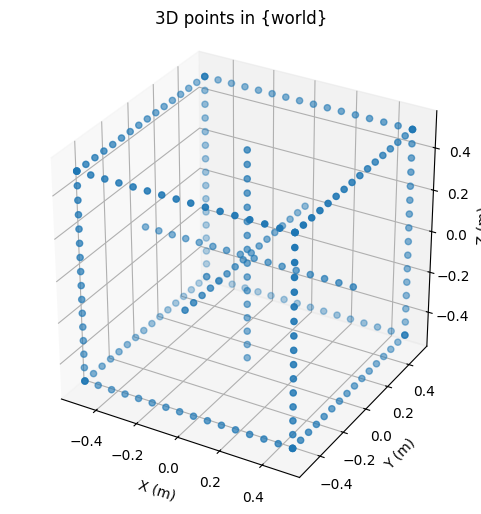

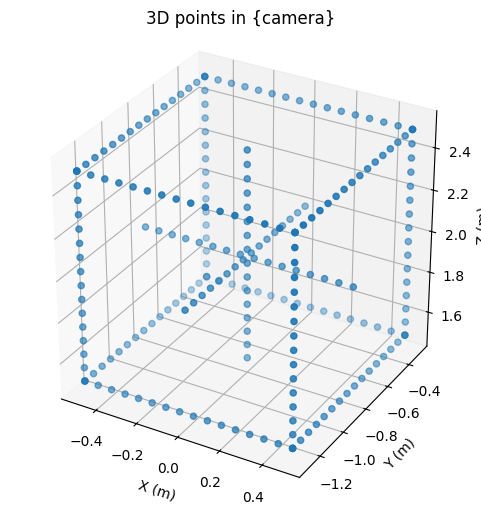

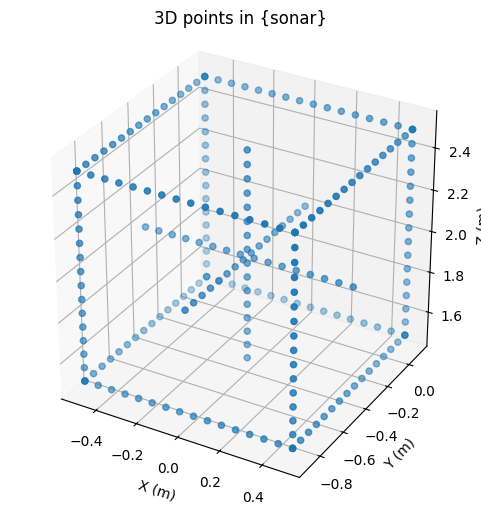

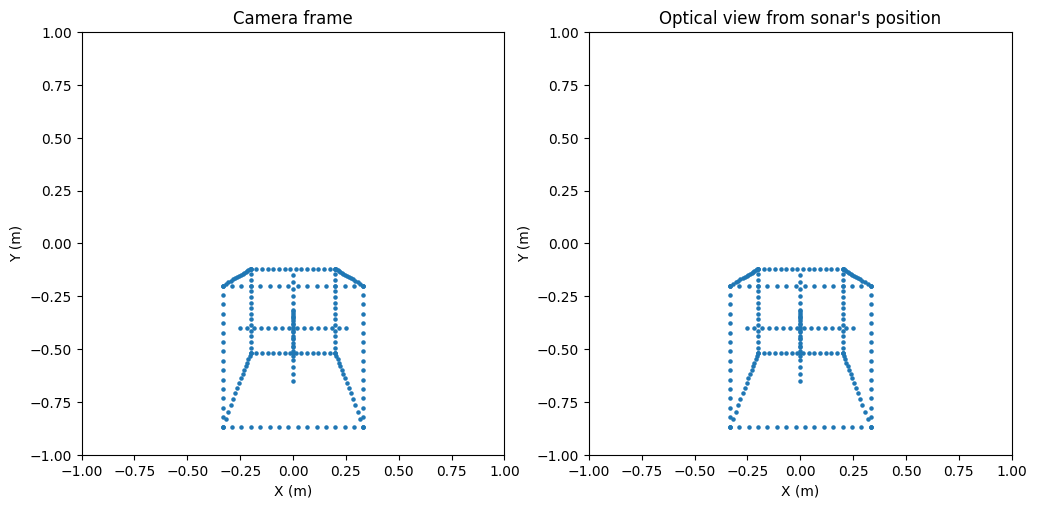

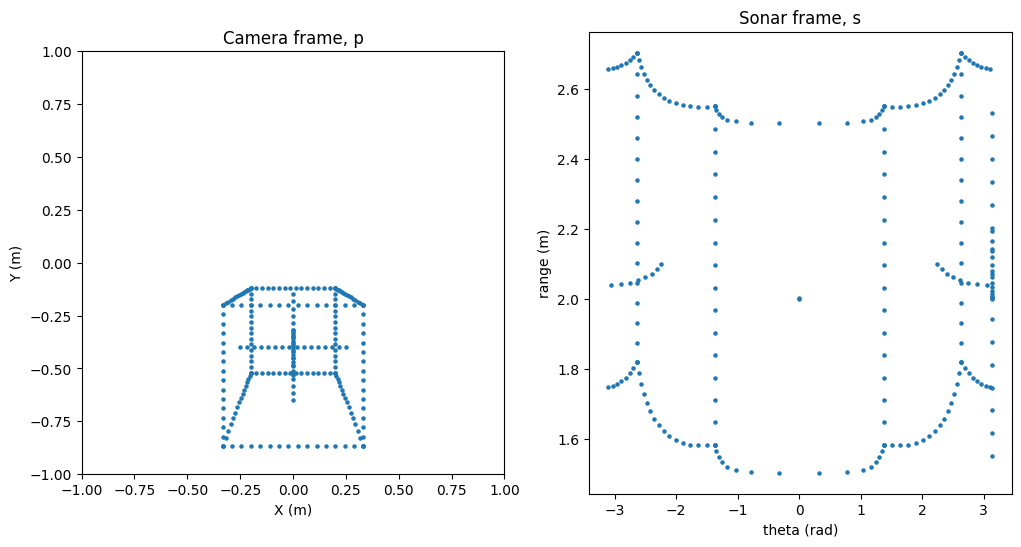

In [33]:
# Plot
# plot_3d(Qw, "3D points in {world}")
# plot_3d(Qc, "3D points in {camera}")
# plot_3d(Qs, "3D points in {sonar}")
plot_dual_pov(p, Qs_proj)
plot_dual_projection(p, s)

plt.show()


1.503699142485328 2.703701166919155
0.08590533770643485 0.15453898911012753


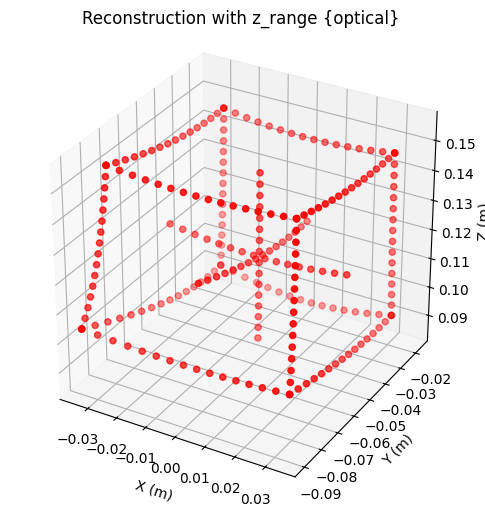

In [32]:
def range_solution(s, p, K, R, t):
    """
    Closed-form range solution for range measurements.

    Args:
        s: 2D points in {sonar} as (r, theta), shape (2, n)
        p: 2D points in {camera}, shape (2, n)
        K: Camera intrinsics matrix
        R: Rotation matrix from {camera} to {sonar}
        t: Translation vector from {camera} to {sonar}

    Returns:
        z: range measurements, shape (n,)
    """
    f = K[0, 0]
    range_ = s[0, :]
    p =  np.vstack((p, f*np.ones(p.shape[1])))
    z = f * ((range_ * np.linalg.norm(p) - t.T @ R @ p)/np.linalg.norm(p)**2)
    return z


z_range = range_solution(s, p, K, R, t)
print(np.min(z_range), np.max(z_range))

# Plot
Xo = p[0, :] * z_range / f
Yo = p[1, :] * z_range / f
reconstructed = np.vstack((Xo, Yo, z_range))
plot_3d(reconstructed, "Reconstruction with z_range {optical}", c="r")

In [29]:
r1 = R[:, 0].reshape(3, 1)
r2 = R[:, 1].reshape(3, 1)

theta1 = s[1, 0]
p1 = p[:, 0].reshape(2, 1)
p1 = np.vstack((p1, np.ones(1)))
print(p1.shape)
print((r1 - np.tan(theta1)*r2).shape)

# np.dot(r1 - np.tan(theta1)*r2, p1)
(r1 - np.tan(theta1)*r2 ).T @ p1

(3, 1)
(3, 1)


array([[0.22222222]])

(240,)


C:\Users\yufan\AppData\Local\Temp\ipykernel_13784\3928020285.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i] = num / den
C:\Users\yufan\AppData\Local\Temp\ipykernel_13784\3928020285.py:32: RuntimeWarning: divide by zero encountered in divide
  z[i] = num / den
C:\Users\yufan\AppData\Local\Temp\ipykernel_13784\3928020285.py:40: RuntimeWarning: invalid value encountered in multiply
  Xo = p[0, :] * z_azi / f


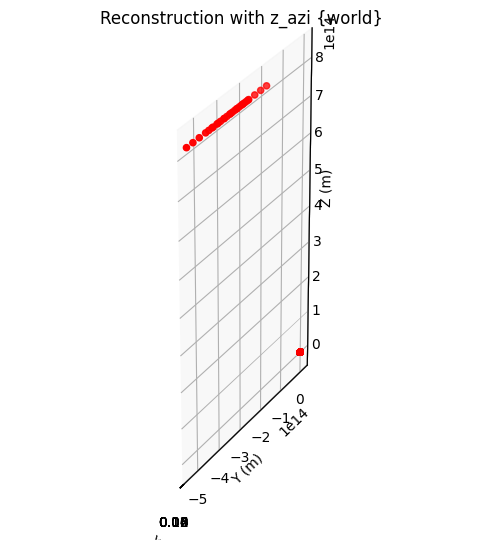

In [30]:
def azimuth_solution(s, p, K, R, t):
    """
    Closed-form azimuth solution for range measurements.

    Args:
        s: 2D points in {sonar} as (r, theta), shape (2, n)
        p: 2D points in {camera}, shape (2, n)
        K: Camera intrinsics matrix
        R: Rotation matrix from {camera} to {sonar}
        t: Translation vector from {camera} to {sonar}

    Returns:
        z: range measurements, shape (n,)
    """
    f = K[0, 0]
    r1 = R[:, 0].reshape(3, 1)
    r2 = R[:, 1].reshape(3, 1)
    theta = s[1, :] # shape (n,)
    tx = t[0, 0]    # scalar
    ty = t[1, 0]    # scalar
    p = np.vstack((p, f*np.ones(p.shape[1])))
    # print((r1 - np.tan(theta) * r2).shape)
    # z = (r1 - np.tan(theta) * r2).T @ p
    # z = f * ( np.tan(theta) * ty - tx) / ((r1 - np.tan(theta) * r2).T @ p)

    z = np.zeros(s.shape[1])
    for i in range(s.shape[1]):
        theta = s[1, i]
        pi = p[:, i].reshape(3, 1)
        num = f * (np.tan(theta) * ty - tx)
        den = (r1 - np.tan(theta) * r2).T @ pi
        z[i] = num / den
    return z


z_azi = azimuth_solution(s, p, K, R, t)
print(z_azi.shape)

# Plot
Xo = p[0, :] * z_azi / f
Yo = p[1, :] * z_azi / f
reconstructed = np.vstack((Xo, Yo, z_azi))
plot_3d(reconstructed, "Reconstruction with z_azi {world}", c="r")